In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import random
from tensorflow.keras import layers

In [2]:
## input and output
input_dir = 'E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/'
target_dir = 'E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/'

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[50:60], target_img_paths[50:60]):
    print(input_path, "|", target_path)

Number of samples: 2


In [32]:
#image augmentation


resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(480, 480),
  layers.Rescaling(1./225),
  layers.RandomContrast(factor = [0.1, 1.9]),
  #layers.Lambda(random_flip_on_probability)
])
def random_left_right(image1, image2):
  if random.uniform(0, 1) > 0.5:
    image1 = tf.image.flip_left_right(image1)
    image2 = tf.image.flip_left_right(image2)
  
  if random.uniform(0, 1) > 0.5:
    image1 = tf.image.flip_up_down(image1)
    image2 = tf.image.flip_up_down(image2)

  return image1, image2



#display
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['original Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

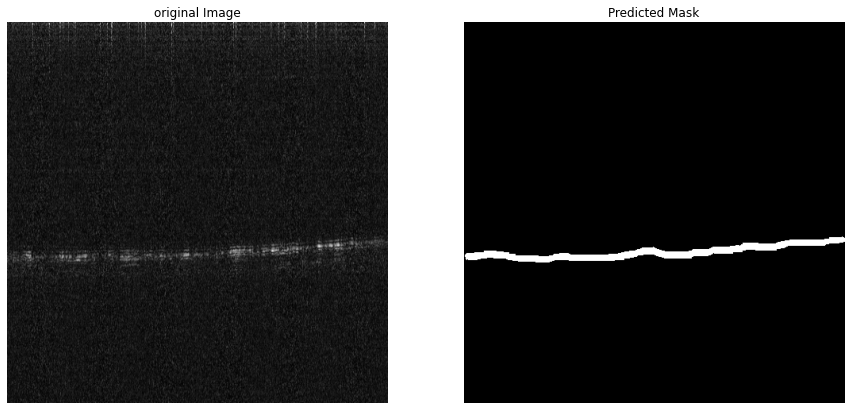

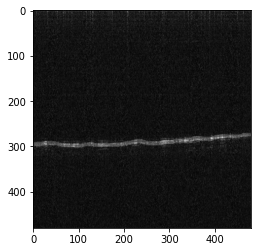

In [50]:
#need to make sure that the input pipeline produce the correct input image and its corresponding mask
i = 1
batch_size = 1
img_size = (480, 480)
batch_input_img_paths = input_img_paths[i : i + batch_size]
batch_target_img_paths = target_img_paths[i : i + batch_size]
x = np.zeros((batch_size,) + img_size + (3,), dtype="float32")
for j, path in enumerate(batch_input_img_paths):
    img = cv2.imread(path)
    img = (img/np.max(img)*225).astype(np.uint8)
    img = resize_and_rescale(img)
    x[j] = img
y = np.zeros((batch_size,) + img_size, dtype="uint8")
for j, path in enumerate(batch_target_img_paths):
    img = load_img(path, target_size=img_size, color_mode="grayscale")
    y[j] = img
    ## Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    ##y[j] -= 1
y = np.expand_dims(y, -1)
x, y = random_left_right(x, y)
y = y[:, :, :, 0]
display([x[0], np.repeat(np.expand_dims(y[0],-1),3,-1)])
#combine image
#add_image = cv2.addWeighted(tf.keras.utils.array_to_img(x[1]), 0.6, tf.keras.utils.array_to_img(np.repeat(np.expand_dims(y[1],-1),3,-1)), 0.2, 0)
plt.imshow(tf.keras.utils.array_to_img(x[0]), cmap = "gray")
plt.imshow(tf.keras.utils.array_to_img(np.repeat(np.expand_dims(y[0],-1),3,-1)), cmap = "jet", alpha = 0.2)
## always test new code before implementing it. Sometimes no errors doesn't mean no errors